# NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# We use an additional import as our raw data is over 600Mo uncompressed
import zipfile
from queue import *

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what features you have and what are your labels. Please provide below a Panda dataframe where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

### Description
Using the US-Senators dataset we have the following characteristics:

* Nodes: senators
* Edges: similarity
* Features: voting position on bills
* Labels: political party

Note that for simplicity we start by using only data from the 115th congress. We also do not take into account senators that weren't in the office for the entire duration of the congress.

### Data import
Note that we have compiled our own dataset after downloading relevant data from the ProPublica Congress API. If you would like to verify how each part of the dataset was acquired, please see the "Data-Acquisition" Jupyter notebook handed with the submission.

In [3]:
VOTE_DATA_PATH = '../data/votes/'
ADJACENCY_PATH = '../data/adjacency_matrices/'
ADJACENCY_COSINE_PATH = ADJACENCY_PATH + 'cosine'
ADJACENCY_EUC_PATH = ADJACENCY_PATH + 'eucledian'

ZIPPED_VOTES = zipfile.ZipFile(VOTE_DATA_PATH+'votes.zip')

vote_data_files = [x.filename for x in ZIPPED_VOTES.infolist() if x.filename.startswith('votes_')]

### Data processing

In [4]:
def interpret_position(positions):
    r = positions.copy()
    r = r.apply(lambda x : 1 if x == "Yes" else ( -1 if x == "No" else 0 ))
    
    return r

In [5]:
USEFUL_COLUMNS = ['id','bill.number','congress','member_id','question','position', 'timestamp']

def process_vote_file(file_path, since_congress=115):
    print("Processing vote data for {file}".format(file=file_path), end='\r')
    ifile = ZIPPED_VOTES.open(file_path)
    
    # Read data
    df = pd.read_csv(ifile)

    # We drop entries without bill number as they lead to invalid bill IDs
    df = df[df['bill.number'].notna()]
    
    # We drop entries without roll call value
    df = df[df['roll_call'].notna()]
    
    # As there can be several votes per bill we need to build a unique ID
    df['id'] = df['bill.bill_id'].map(str) + "-" + df['roll_call'].map(str)

    # Some bill IDs and roll call numbers are poorly filled, leading to duplicates
    df = df.drop_duplicates('id')
    
    # Build timestamps
    df['timestamp'] = pd.to_datetime(df.date.map(str) + " " + df.time.map(str))
    
    # Keep only useful columns
    df = df[USEFUL_COLUMNS]
    
    # Keep only relevant congresses
    df = df[df['congress'] >= since_congress]
    
    # Convert position to numeric
    df['position'] = interpret_position(df['position'])
    
    return df

In [10]:
NOMINATION_VOTE = "On the Nomination"
MOTION_VOTE = "On the Motion"
AMENDMENT_VOTE = "On the Amendment"
MOTION_TO_TABLE_VOTE = "On the Motion to Table"
CLOTURE_MOTION_VOTE = "On the Cloture Motion"
BILL_PASSAGE = "On Passage of the Bill"

def build_vote_matrix(questions, data):
    """
    Given a list of questions, build a vote matrix.
    Index are senators IDs, columns are vote IDs and values are the respective positions
    of the senators with respect to the question (Yes, No, blank or NaN if the senator
    did not take part in the vote)
    
    Data should contain the following columns:
        - senators ID (member_id)
        - vote ID (id)
        - position (position)
    """    
    
    vote_matrix = data 
    
    if len(questions) > 0:
        vote_matrix = data[data['question'].isin(questions)]
        
    vote_matrix = vote_matrix.pivot(columns='id', index='member_id', values='position')
    
    return vote_matrix

In [11]:
def build_commities_matrix(raw_commities):
    res = raw_commities.copy()
    res['pos'] = 1
    res = res.drop_duplicates(['id','subcomitee'])
    res = res.pivot(columns = 'subcomitee',index='id', values='pos')
    res = res.fillna(0)
    return res

In [12]:
# Compiling data about senators
raw_senators = pd.read_csv("../data/senate_members/senate_members_115.csv")

# Compiling data about votes
df_list = []

for filepath in vote_data_files:
    vote_data = process_vote_file(filepath)
    df_list.append(vote_data)
    
raw_votes = pd.concat(df_list)
raw_commities = pd.read_csv("../data/commitees/commitees_115/members.csv")

In [75]:
#features_vote = build_vote_matrix([BILL_PASSAGE], raw_votes).dropna(0)
#features_commities = build_commities_matrix(raw_commities).dropna(0)
#features = features_vote.merge(features_commities, left_index=True, right_index=True)

features = build_vote_matrix([BILL_PASSAGE, AMENDMENT_VOTE], raw_votes).dropna(0)
features = features.merge(raw_senators[['id', 'party']], left_index=True, right_on='id').set_index('id')
features.head(3)

,hconres71-115-220,hconres71-115-221,hconres71-115-222,hconres71-115-223,hconres71-115-225,hconres71-115-226,hconres71-115-228,hconres71-115-229,hconres71-115-230,hconres71-115-232,...,s2554-115-209,s722-115-144,s722-115-145,s722-115-146,s722-115-147,s84-115-27,s89-115-102,sconres3-115-20,sconres3-115-3,party
id,,,,,,,,,,,,,,,,,,,,,
A000360,1,-1,-1,1,-1,1,-1,1,-1,-1,...,1,1,1,1,1,0,1,-1,-1,R
B000575,0,0,0,0,-1,1,-1,1,-1,-1,...,1,1,1,1,1,1,1,-1,0,R
B000944,1,1,1,1,1,-1,1,1,1,1,...,1,1,1,1,1,1,1,1,-1,D


### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in the  [graph from edge list]() demo.

2) The edges are not given to you. In that case you will have to create a feature graph. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. In the [graph from features]() demo Benjamin showed you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and explore other distances as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to sparsify by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

#### Distances

In [76]:
def euclidean_distance(x,y):
    """
    Given two vectors of the same length, return the euclidean distance between the two vectors.
    """
    return np.sqrt(np.sum(np.power(x-y,2)))

def hamming_distance(x,y):
    """
    Given two vectors of the same length, return the hamming distance betweem the two vectors.
    """
    a = x != y
    return a.sum()

def cosine_similarity(x,y):
    """
    Given two vectors of the same length, return the cosine similarity betweem the two vectors.
    """
    return 0.5 * (1 + (np.dot(x,y))/(np.linalg.norm(x)*np.linalg.norm(y)))

#### Kernels

In [77]:
def gaussian_kernel(distance_matrix):
    """
    Given a matrix calculate the gaussian kernel of it. The variance is given by the mean of the matrix. 
    """
    kernel_width = distance_matrix.mean()
    res = np.exp(-distance_matrix**2 / kernel_width**2)
    return res

def linear_kernel(distance_matrix):
    """
    Given a matrix calculate the linear kernel of it.
    """
    max_adj = np.max(distance_matrix)
    min_adj = np.min(distance_matrix)
    res = 1 - (distance_matrix - min_adj)/(max_adj-min_adj)
    return res

def identity_kernel(distance_matrix):
    """
    Given a matrix calculate the indentity kernel of it. The indentity kernel will not change the matrix.
    """
    return distance_matrix

#### Sparsify

In [78]:
def sparsify_with_limit(adjacency, limit = 0.35):
    """
    Sparsify a matrix by putting each of element of the adjacency matrix to 0
    if it is below the limit.
    """
    res = adjacency.copy()
    res[res < limit] = 0
    return res

def sparsify_with_max_neighbors(adjacency, max_neighbors = 45):
    """
    Sparsify a matrix by greedily adding the links of higher weight such that each node
    doesn't have more neighbors than max_neighbors 
    """
    number_of_nodes = adjacency.shape[0]    
    
    index_sort = np.argsort(adjacency,axis=None)[::-1]
    flatten_adjacency = adjacency.flatten()
    res = np.zeros(adjacency.shape)
    counter = 0

    for i in range(len(index_sort)):
        if counter >= max_neighbors * number_of_nodes:
            break
        
        node_1 = index_sort[i] % number_of_nodes
        node_2 = int(index_sort[i] / number_of_nodes)

        if(np.count_nonzero(res[node_1]) < max_neighbors and np.count_nonzero(res[node_2]) < max_neighbors):
            res[node_1,node_2] = flatten_adjacency[index_sort[i]]
            res[node_2,node_1] = flatten_adjacency[index_sort[i]]
            counter += 1
                   
    return res

#### Adjacency matrix creation

In [79]:
def to_binary_adjacency_matrix(adjacency_matrix):
    # Mask the adjacency matrix
    masked_adjacency = adjacency_matrix.copy()
    masked_adjacency[masked_adjacency > 0] = 1
    
    return masked_adjacency

def get_adjacency_matrix(features_matrix, distance_function, kernel_function,sparsify):
    """
    Get the adjacency matrix of the features by first applying the distance function, 
    then the kernel_function and finally the sparsify function passed in arguments.
    """
    number_of_nodes = features_matrix.shape[0]
    distance_matrix = np.asarray(
        [
            [distance_function(features_matrix[i],features_matrix[j]) for j in range(number_of_nodes)] 
            for i in range(number_of_nodes)
        ])    
    kernel = kernel_function(distance_matrix)
    np.fill_diagonal(kernel, 0)
    return sparsify(kernel)

In [111]:
features_matrix = features.drop('party',1).values
#features_matrix = np.asarray([[1,0,0,1],[1,0,0,1],[1,1,0,0],[-1,1,1,-1],[-1,0,0,-1]]) # As an example

adjacency_euclidean = get_adjacency_matrix(
    features_matrix,
    euclidean_distance,
    gaussian_kernel,
    lambda arg : sparsify_with_limit(arg,0.7)
)
np.save(ADJACENCY_EUC_PATH,adjacency_euclidean)

adjacency_cosine = get_adjacency_matrix(
    features_matrix,
    cosine_similarity,
    identity_kernel,
    lambda arg : sparsify_with_limit(arg,0.92)
)
np.save(ADJACENCY_COSINE_PATH,adjacency_cosine)

adjacency = adjacency_euclidean
n_nodes = adjacency.shape[0]

print('The adjacency matrix: \n \n {} \n \n'.format(adjacency))
print('Number of nodes: {}'.format(n_nodes))

The adjacency matrix: 
 
 [[0.         0.74809231 0.         ... 0.         0.         0.        ]
 [0.74809231 0.         0.         ... 0.         0.         0.73612692]
 [0.         0.         0.         ... 0.77260972 0.72435292 0.        ]
 ...
 [0.         0.         0.77260972 ... 0.         0.         0.        ]
 [0.         0.         0.72435292 ... 0.         0.         0.        ]
 [0.         0.73612692 0.         ... 0.         0.         0.        ]] 
 

Number of nodes: 96


## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

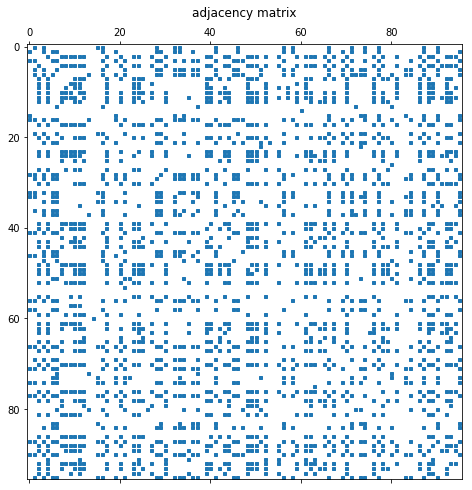

In [112]:
plt.figure(figsize=(8,8))
plt.spy(adjacency, markersize=3)
plt.title('adjacency matrix')
plt.show()

In this part we tried to compute the distance between senators using two metrics in order to compare their fitness to our problem:

In [113]:
reps = np.argwhere(features.party.values == 'R').squeeze()
dems = np.argwhere(features.party.values == 'D').squeeze()

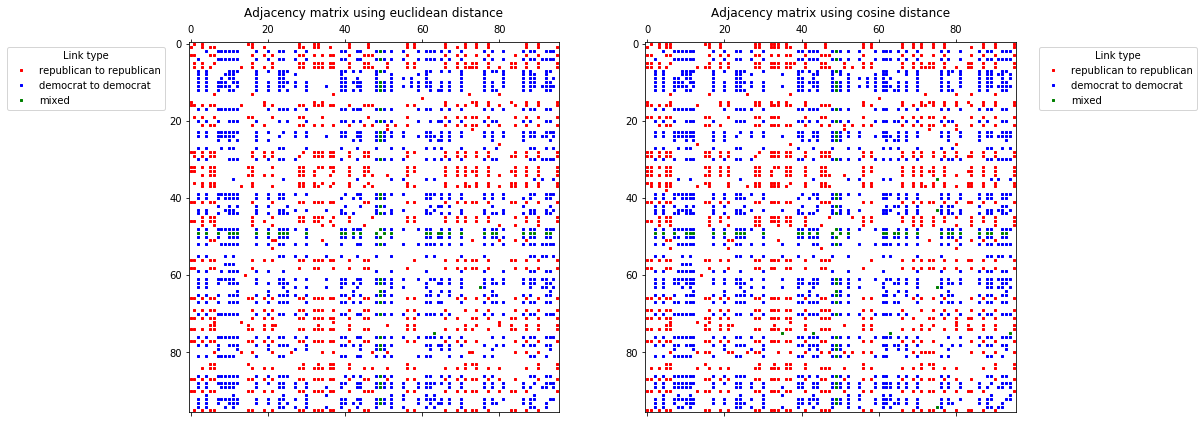

In [114]:
def spy_by_type(adjacency, subplot_number, title):
    ax = plt.subplot(subplot_number)
    
    binary_adjacency = to_binary_adjacency_matrix(adjacency)
    reps_to_reps = np.zeros_like(binary_adjacency)
    reps_to_reps[np.ix_(reps, reps)] = 1
    reps_to_reps = reps_to_reps * binary_adjacency

    dems_to_dems = np.zeros_like(binary_adjacency)
    dems_to_dems[np.ix_(dems, dems)] = 1
    dems_to_dems = dems_to_dems * binary_adjacency

    remainder = binary_adjacency.copy()
    remainder = remainder - reps_to_reps - dems_to_dems

    plt.spy(reps_to_reps, color='r', markersize = 2, label="republican to republican")
    plt.spy(dems_to_dems, color='b', markersize = 2, label="democrat to democrat")
    plt.spy(remainder, color='g', markersize = 2,label="mixed")
    plt.title(title)
    
    legend_bbox = (1.05,1) if subplot_number % 2 == 0 else (-0.05,1) 
    legend_loc = 'upper left' if subplot_number % 2 == 0 else 'upper right' 
    ax.legend(bbox_to_anchor=legend_bbox, loc=legend_loc, title='Link type')


plt.figure(figsize=(15,15))
spy_by_type(adjacency_euclidean, 221, 'Adjacency matrix using euclidean distance')
spy_by_type(adjacency_cosine, 222, 'Adjacency matrix using cosine distance')

plt.show()

As we can see, the cosine similarity and the euclidean distance gives us similar adjacency matrices.

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [84]:
total_links_fully_connected = n_nodes * (n_nodes - 1)/2

print('Number of links: {}'.format(np.count_nonzero(adjacency) / 2))
print('Total possible number of links: {}'.format(total_links_fully_connected))
print('Ratio of links in our network: {}'.format((np.count_nonzero(adjacency) / 2)/total_links_fully_connected))
print('Average degree in our network: {}'.format(np.count_nonzero(adjacency,1).mean()))

Number of links: 1107.0
Total possible number of links: 4560.0
Ratio of links in our network: 0.24276315789473685
Average degree in our network: 23.0625


The number of edges is given by: $L_{max}$ = $\frac{N \cdot (N-1)}{ 2} $

Our network is not fully connected. We can observe that our average degree is less than half of the number of nodes.

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

**Your answer here.**

Our graph is undirected.

### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [85]:
features.to_csv('features.csv')
np.save('adjacency', adjacency)

### Question 4

Are the edges of your graph weighted?

**Your answer here.**

Yes, our graph has weighted edges.

### Question 5

What is the degree distibution of your network? 

In [86]:
degree = np.count_nonzero(adjacency,1)

assert len(degree) == n_nodes

Execute the cell below to see the histogram of the degree distribution.

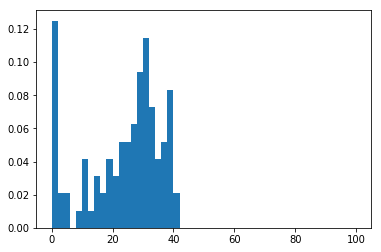

In [87]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights, bins=np.arange(0, 99 + 2, 2));
plt.show()

What is the average degree?

In [88]:
average_degree = degree.mean()

print('The average degree is: {}'.format(average_degree))

The average degree is: 23.0625


### Question 6

Comment on the degree distribution of your network.

**Your answer here.**

As we can see most of our nodes have 40 neighbors. This is coherent with our sparsification method where we limited the number of neighbors to 40 for each node.

In [89]:
pd.Series(degree).describe()

count    96.000000
mean     23.062500
std      12.367881
min       0.000000
25%      14.000000
50%      27.000000
75%      32.250000
max      40.000000
dtype: float64

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [90]:
def bfs(matrix,starting_node = 0):
    """
    Use the BFS algorithm to explore the graph. Return the visited_nodes that can be reached from the starting_node.
    """
    neighbors = Queue()
    neighbors.put(starting_node)
    visisted_nodes = [starting_node]
    
    while not neighbors.empty():
        node = neighbors.get()

        for elem in list(np.argwhere(matrix[node])):
            if elem not in visisted_nodes:
                neighbors.put(elem[0])
                visisted_nodes.append(elem[0])
            
    return np.asarray(visisted_nodes)

In [91]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    
    return len(bfs(adjacency)) == len(adjacency)

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [92]:
connected_graph(adjacency)

False

### Question 8

Write a function that extracts the connected components of a graph.

In [93]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    components = []
    nodes = set(range(adjacency.shape[0]))
    
    while len(nodes) != 0:
        start_node = nodes.pop()

        component = bfs(adjacency, start_node)
        components.append(component)
        nodes = nodes.difference(set(component))
    
    return components


# Helper function
def find_max_component(adjacency):
    components = find_components(adjacency)
    return components[np.asarray([len(component) for component in components]).argmax()]

def get_adjacency_biggest_component(adjacency):
    max_component = find_max_component(adjacency)
    return adjacency[np.ix_(max_component,max_component)]

How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

In [94]:
print('There are {} different components in the graph.'.format(len(find_components(adjacency))))
print('The biggest component has a size of {}.'.format(len(find_max_component(adjacency))))

There are 10 different components in the graph.
The biggest component has a size of 47.


### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [95]:
def compute_shortest_path_lengths(adjacency, source):
    """Compute the shortest path length between a source node and all nodes.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    
    Returns
    -------
    list of ints
        The length of the shortest path from source to all nodes. Returned list should be of length n_nodes.
    """
    
    # Your code here.
    
    number_nodes = adjacency.shape[0]
    
    visited_nodes = set()
    shortest_path_lengths = np.ones(number_nodes) * np.inf
    shortest_path_lengths[source] = 0
    
    while len(visited_nodes) != number_nodes:
        sorted_distances = np.argsort(shortest_path_lengths)        
        i = 0
        
        while sorted_distances[i] in visited_nodes:
            i += 1

        elem_with_smallest_dist = sorted_distances[i]        
        visited_nodes.add(elem_with_smallest_dist)
        
        for neighbor in list(np.argwhere(adjacency[elem_with_smallest_dist])):
            if neighbor[0] not in visited_nodes:
                shortest_path_lengths[neighbor] = min(
                    shortest_path_lengths[neighbor],
                    shortest_path_lengths[elem_with_smallest_dist] + 1
                )
            
    return shortest_path_lengths

In [96]:
compute_shortest_path_lengths(adjacency,0)

array([ 0.,  1., inf,  1., inf,  2.,  2., inf, inf, inf, inf, inf, inf,
        2., inf,  1.,  1., inf, inf,  2., inf,  2.,  3., inf, inf, inf,
        3., inf,  1.,  2., inf, inf,  1.,  1.,  2., inf,  2.,  2., inf,
       inf, inf,  1., inf, inf, inf,  2.,  1.,  2., inf, inf, inf,  2.,
       inf,  3., inf, inf,  1., inf,  1., inf, inf, inf, inf, inf, inf,
       inf,  1., inf, inf,  2., inf,  1.,  3.,  2.,  1., inf, inf,  1.,
       inf, inf,  2., inf, inf,  2.,  2., inf, inf,  1., inf, inf,  1.,
       inf, inf, inf, inf,  2.])

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [97]:
def get_diameter(adjacency):
    diameter = -1
    truncated_adjacency = get_adjacency_biggest_component(adjacency)
    
    for node in range(truncated_adjacency.shape[0]):
        diameter = max(
            *compute_shortest_path_lengths(truncated_adjacency,node),
            diameter
        )

    return diameter

get_diameter(adjacency)

4.0

### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

In [98]:
def compute_all_paths(adjacency, length):
    
     return np.linalg.matrix_power(
         to_binary_adjacency_matrix(adjacency), 
         length
     )

def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    target: int
        The target node. A number between 0 and n_nodes-1.
    length: int
        The path length to be considered.
    
    Returns
    -------
    int
        The number of paths.
    """
    
    return compute_all_paths(adjacency, length)[source][target]

Test your function on 5 pairs of nodes, with different lengths.

In [99]:
print(compute_paths(adjacency, 0, 10, 1))
print(compute_paths(adjacency, 0, 10, 2))
print(compute_paths(adjacency, 0, 10, 3))
print(compute_paths(adjacency, 23, 67, 2))
print(compute_paths(adjacency, 15, 93, 4))

0.0
0.0
0.0
29.0
0.0


### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [100]:
"""
We use the same trick as the one used in the compute_paths function but this time we do not select
a particular coordinate. It then suffices to sum all the entries in the resulting matrix. Note that it is necessary
to divide the result by two because each path will be counted twice. (Once from A to B and once from B to A)
""" 
compute_all_paths(adjacency, 3).sum() / 2.0

981665.0

### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

In [101]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node. As the graph we counted each edge twice.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """
    
    binary_adj = to_binary_adjacency_matrix(adjacency)  
    neighbors = np.nonzero(binary_adj[node]) # Select neighbors of given node

    if len(neighbors[0]) > 1:
        neighbors = np.squeeze(neighbors)
    else:
        # We assume the clustering is not defined for nodes that have no or 1 neighbor.
        return np.nan
    
    # Select only links between neighbors of the given node
    neighbors_links = binary_adj[np.ix_(neighbors, neighbors)] 
    
    # By symmetry, summing over the whole matrix counts each link twice
    two_L = np.sum(neighbors_links) 
    k = len(neighbors)
    
    if k == 0:
        return np.nan
    
    return two_L / (k * (k-1))

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [102]:
total_clustering_coeff = 0.0
n = 0
truncated_adjacency = get_adjacency_biggest_component(adjacency)

for i in range(len(adjacency)):
    clustering_coeff_i = compute_clustering_coefficient(adjacency, i)
    if not np.isnan(clustering_coeff_i):
        n += 1
        total_clustering_coeff += clustering_coeff_i
    
print("The average clustering coefficient is {coeff}".format(coeff=total_clustering_coeff / float(n)))

The average clustering coefficient is 0.8324685418712092
